In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

In [2]:
x_train = pd.read_csv('data/s2e/audio_train.csv')
x_test = pd.read_csv('data/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(7837, 10)


In [3]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(7837, 10) (1960, 10)
{0: 860, 1: 1309, 2: 2327, 3: 1007, 4: 949, 5: 1385}


In [4]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())

Test Set Accuracy =  0.560
Test Set F-score =  0.560
Test Set Precision =  0.572
Test Set Recall =  0.573
Confusion matrix, without normalization
[[ 79  38  95   1  14  16]
 [ 42  57 172   1   2  53]
 [ 27  49 423   3  14  90]
 [  0   0   0 233   0   0]
 [  0   0   0   0 228   0]
 [ 17  31 184   1  13  77]]


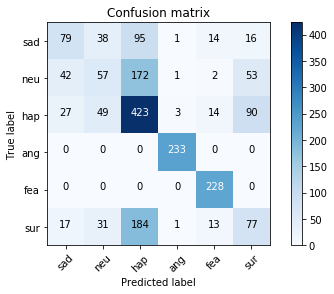

In [5]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.556
Test Set F-score =  0.560
Test Set Precision =  0.569
Test Set Recall =  0.568
Confusion matrix, without normalization
[[ 69  47  91   1   9  26]
 [ 44  66 158   1   2  56]
 [ 33  53 418   4   9  89]
 [  0   0   0 233   0   0]
 [  0   0   0   0 228   0]
 [ 21  29 190   1   6  76]]


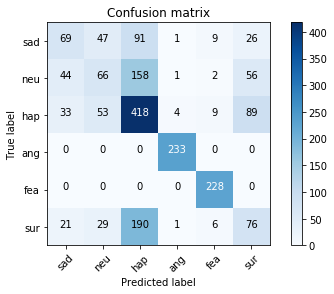

In [12]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.410
Test Set F-score =  0.365
Test Set Precision =  0.422
Test Set Recall =  0.359
Confusion matrix, without normalization
[[ 77  33 101  14  12   6]
 [ 36  52 180  18  13  28]
 [ 21  29 445  35  30  46]
 [  0   0  94 107   9  23]
 [  7  11 103  20  80   7]
 [  6  24 209  21  20  43]]


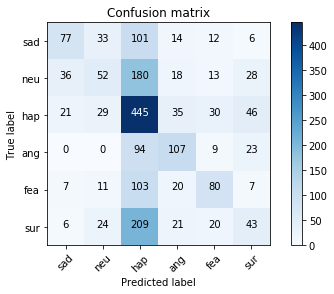

In [7]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.337
Test Set F-score =  0.152
Test Set Precision =  0.174
Test Set Recall =  0.215
Confusion matrix, without normalization
[[ 73  15 155   0   0   0]
 [ 42  14 271   0   0   0]
 [ 28   4 574   0   0   0]
 [  4   0 229   0   0   0]
 [ 25   5 198   0   0   0]
 [ 11   7 305   0   0   0]]


/home/gsahu/dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gsahu/dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


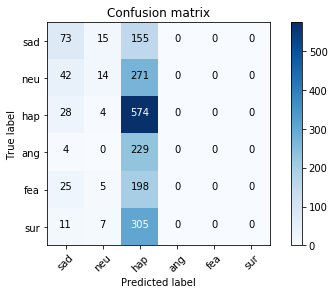

In [13]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('pred_probas/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.313
Test Set F-score =  0.091
Test Set Precision =  0.196
Test Set Recall =  0.172
Confusion matrix, without normalization
[[  8   3 232   0   0   0]
 [  2   1 324   0   0   0]
 [  1   0 605   0   0   0]
 [  0   0 233   0   0   0]
 [  1   0 227   0   0   0]
 [  1   0 322   0   0   0]]


/home/gsahu/dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gsahu/dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


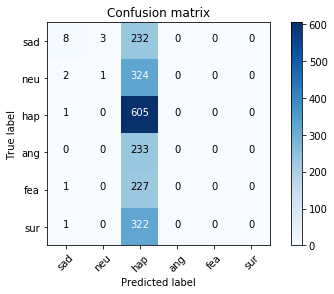

In [14]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.334
Test Set F-score =  0.149
Test Set Precision =  0.178
Test Set Recall =  0.209
Confusion matrix, without normalization
[[ 60  18 165   0   0   0]
 [ 29  16 282   0   0   0]
 [ 16  11 579   0   0   0]
 [  0   0 233   0   0   0]
 [ 18   7 203   0   0   0]
 [  8   4 311   0   0   0]]


/home/gsahu/dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gsahu/dev/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


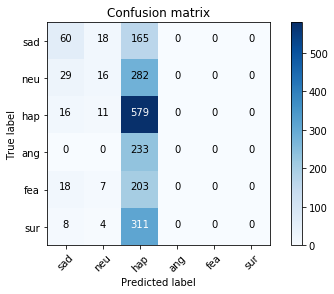

In [15]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

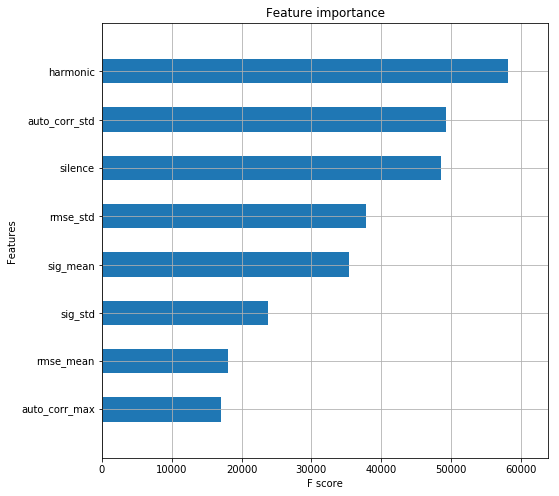

In [16]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

In [17]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.11087918, 0.10637122, 0.14795   , 0.16581726, 0.11913815,
       0.0974914 , 0.14128315, 0.11106968], dtype=float32)

In [18]:
top_n = [3, 5, 6, 7, 8]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=1200, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 3 features:
Test Set Accuracy =  0.551
Test Set F-score =  0.547
Test Set Precision =  0.558
Test Set Recall =  0.559
Stats for top 5 features:
Test Set Accuracy =  0.549
Test Set F-score =  0.557
Test Set Precision =  0.564
Test Set Recall =  0.565
Stats for top 6 features:
Test Set Accuracy =  0.558
Test Set F-score =  0.563
Test Set Precision =  0.571
Test Set Recall =  0.572
Stats for top 7 features:
Test Set Accuracy =  0.547
Test Set F-score =  0.553
Test Set Precision =  0.558
Test Set Recall =  0.564
Stats for top 8 features:
Test Set Accuracy =  0.556
Test Set F-score =  0.560
Test Set Precision =  0.569
Test Set Recall =  0.568


In [19]:
import torch
import pickle
import numpy as np
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from lstm_classifier.s2e.lstm_classifier import LSTMClassifier
from lstm_classifier.s2e import utils
from lstm_classifier.s2e.config import model_config as config

emotion_dict = {'ang': 0, 'hap': 1, 'sad': 2, 'fea': 3, 'sur': 4, 'neu': 5}

device = 'cuda:{}'.format(config['gpu']) if \
         torch.cuda.is_available() else 'cpu'

model = LSTMClassifier(config)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

train_batches = [[torch.FloatTensor(np.array(x_train)), torch.LongTensor(np.array(y_train))]]
test_pairs = [torch.FloatTensor(np.array(x_test)), torch.LongTensor(np.array(y_test))]

best_perf = {}
best_acc = 0

print(config['n_epochs'])
for epoch in range(config['n_epochs']):
    losses = []
    for batch in train_batches:
        inputs = batch[0].unsqueeze(0)  # frame in format as expected by model
        targets = batch[1]
        inputs = inputs.to(device)
        targets = targets.to(device)

        model.zero_grad()
        optimizer.zero_grad()

        predictions = model(inputs)
        predictions = predictions.to(device)

        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # evaluate
    with torch.no_grad():
        inputs = test_pairs[0].unsqueeze(0)
        targets = test_pairs[1]

        inputs = inputs.to(device)
        preds = model(inputs)
#         predictions = torch.argmax(model(inputs), dim=1)  # take argmax to get class id
#         predictions = predictions.to(device)
#         predictions = np.array(predictions.cpu())

        # evaluate on cpu
        targets = np.array(targets.cpu())
        preds = np.array(preds.cpu().numpy())
        predictions = np.argmax(preds, axis=-1)

        # Get results
        # plot_confusion_matrix(targets, predictions,
        #                       classes=emotion_dict.keys())
        performance = utils.evaluate(targets, predictions)
        
        # Save
        if performance['acc'] > best_acc:
            best_perf = performance
            best_acc = performance['acc']
            with open('pred_probas/lstm_classifier.pkl', 'wb') as f:
                pickle.dump(preds, f)
print(best_perf)

ImportError: cannot import name 'load_data'

Test Set Accuracy =  0.566
Test Set F-score =  0.557
Test Set Precision =  0.573
Test Set Recall =  0.573
Confusion matrix, without normalization
[[ 80  36  97   4   9  17]
 [ 45  53 179   1   5  44]
 [ 32  38 452   6  11  67]
 [  0   0   0 233   0   0]
 [  0   0   0   0 228   0]
 [ 17  26 203   3  10  64]]


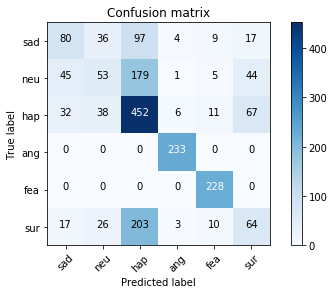

In [26]:
# Load predicted probabilities
# Load predicted probabilities
with open('pred_probas/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

with open('pred_probas/lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)